### 모델 로딩

In [1]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [2]:
from diffusers import StableDiffusionXLPipeline, EulerAncestralDiscreteScheduler, EulerDiscreteScheduler, DPMSolverSinglestepScheduler
import torch

model = "Laxhar/noobai-XL-Vpred-1.0"

pipe = StableDiffusionXLPipeline.from_pretrained(
    model,
    torch_dtype=torch.float16,
    use_safetensors=True)

scheduler_args = {"prediction_type": "v_prediction", "rescale_betas_zero_snr": True}
pipe.scheduler = DPMSolverSinglestepScheduler.from_config(pipe.scheduler.config, timestep_spacing="trailing", **scheduler_args)
#pipe.scheduler = EulerAncestralDiscreteScheduler.from_config(pipe.scheduler.config) // 작동 안 됨(25.02.09)
pipe.enable_xformers_memory_efficient_attention()
pipe = pipe.to("cuda:1") 

/home/hisame2/p3_diffusers/diffusers_venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00, 11.45it/s]


### 로라 적용

In [54]:
## lora 불러오기
pipe.load_lora_weights(".", weight_name="lora/yuina_4ce21_noobvpred_mixed_fp16_hncolab-14.safetensors", adapter_name="yuina_vpred")
#pipe.load_lora_weights(".", weight_name="/home/hisame2/p3_diffusers/lora/dino_noob_vpred-04.safetensors", adapter_name="dino")

In [55]:
## 복수 lora 및 강도 세팅
pipe.set_adapters(["yuina_vpred"], adapter_weights=[0.7])
#pipe.set_adapters(["yuina_vpred", "hbr"], adapter_weights=[0.7, 0.55])

In [53]:
import gc

## lora 해제
pipe.delete_adapters(["yuina_vpred", "dino"])
gc.collect()  # 가비지 컬렉션 실행
torch.cuda.empty_cache()

### 프롬프트 준비

In [5]:
directory = "images"
directory2 = "exif_images" #아래 exif와 이미지 저장 경로
key_file_path = "/home/hisame2/p3_diffusers/key.txt"  #key 저장경로

In [6]:
from compel import Compel, ReturnedEmbeddingsType
compel = Compel(tokenizer=[pipe.tokenizer, pipe.tokenizer_2] , text_encoder=[pipe.text_encoder, pipe.text_encoder_2], returned_embeddings_type=ReturnedEmbeddingsType.PENULTIMATE_HIDDEN_STATES_NON_NORMALIZED, requires_pooled=[False, True], truncate_long_prompts=False)

In [170]:
prompt = "artist:rella, artist:ogipote, cinematic shot, very awa, masterpiece, highres, absurdres, newest, year 2024, pov, dynamic angle, shirakawa yuina, doyagao, pink eyes, eyelashes, looking at viewer, blue headgear, large breasts, slender, seductive pose, platinum blonde hair, off-shoulder stylish sweater, relistic texture and proportion, jeans, groin, navel peek, detailed background, pillo hug, on sofa, from side, sexy pose, morning, sun beam, rim light, lighting particles"
conditioning, pooled = compel.build_conditioning_tensor(prompt)

In [171]:
negative_prompt = "worst quality, off-topic, comic, jpeg artifacts, 3d, hair intakes, scan artifacts, signature, artist name, username, copyright name, logo, speech bubble, narration, lineart, production art, retro artstyle, off-topic, worst quality, oldest, pointy ears, elf, earings, head out of frame, small breasts, medium breasts, closed eyes, closed eyes, peacked cap, hat, halo"
negative_conditioning, _ = compel.build_conditioning_tensor(negative_prompt)
[conditioning_padded, negative_conditioning_padded] = compel.pad_conditioning_tensors_to_same_length([conditioning, negative_conditioning])
#[conditioning, negative_conditioning] = compel.pad_conditioning_tensors_to_same_length([conditioning, negative_conditioning])

In [9]:
from cryptography.fernet import Fernet
from PIL import Image
import piexif
import base64
import os
import shutil


# Fernet 키 생성 및 파일에 저장
def generate_and_save_key(key_file_path):
    key = Fernet.generate_key()
    with open(key_file_path, "w") as key_file:
        key_file.write(key.decode())  # base64 인코딩된 키를 문자열로 저장

# 문자열을 암호화하고 이미지의 EXIF에 저장하는 함수
def encrypt_string_and_add_to_exif(image_path, output_path, string_to_encrypt, key_file_path):
    # 키 파일에서 키를 불러옴
    with open(key_file_path, "r") as key_file:
        key = key_file.read().encode()  # 문자열을 다시 바이트로 인코딩
    cipher_suite = Fernet(key)

    # 문자열 암호화
    encrypted_string = cipher_suite.encrypt(string_to_encrypt.encode())

    # 이미지 로드
    img = Image.open(image_path)
    # EXIF 데이터가 있는지 확인하고, 없으면 초기화
    if 'exif' in img.info:
        exif_dict = piexif.load(img.info['exif'])
    else:
        exif_dict = {'0th': {}, 'Exif': {}, 'GPS': {}, '1st': {}, 'Interop': {}, 'thumbnail': None}

    # 'Exif' 섹션이 있는지 확인하고, 없으면 추가
    if 'Exif' not in exif_dict:
        exif_dict['Exif'] = {}

    # 암호화된 문자열을 UserComment에 추가
    exif_dict['Exif'][piexif.ExifIFD.UserComment] = encrypted_string
    exif_bytes = piexif.dump(exif_dict)

    # 이미지에 암호화된 EXIF 데이터 저장
    img.save(output_path, exif=exif_bytes)

# 사용 예
image_path = ""
output_path = ""
string_to_encrypt = prompt + "negative" + negative_prompt

# 키 생성 및 저장

if not os.path.exists(key_file_path):
    generate_and_save_key(key_file_path)
    print("새로운 키가 생성되어 저장되었습니다.")
else:
    print("기존의 키를 사용합니다.")

# 문자열 암호화 및 EXIF에 저장
#encrypt_string_and_add_to_exif(image_path, output_path, string_to_encrypt, key_file_path)

기존의 키를 사용합니다.


### 이미지 생성

100%|██████████| 40/40 [00:15<00:00,  2.62it/s]


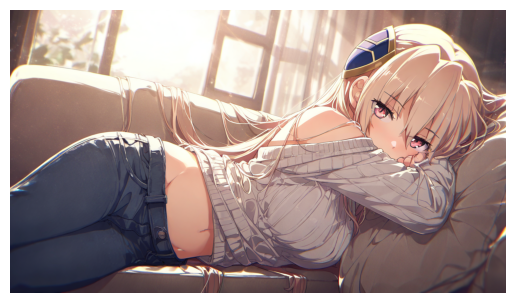

In [172]:
import matplotlib.pyplot as plt
import datetime
import os
import gc
import torch  # torch 임포트 추가

if not os.path.exists(directory):
    os.makedirs(directory)
if not os.path.exists(directory2):
    os.makedirs(directory2)

with torch.no_grad():  # torch.no_grad() 컨텍스트 시작
# デフォルトサイズ(1024x1024)
    image = pipe(
        prompt_embeds=conditioning_padded,
        negative_embeds=negative_conditioning_padded,
        pooled_prompt_embeds=pooled,
        guidance_scale=4,
        num_inference_steps=40,
        height=768,
        width=1344
        ).images[0]
    torch.cuda.empty_cache()

# 현재 날짜와 시간을 기반으로 파일 이름 생성
filename = datetime.datetime.now().strftime('%Y%m%d%H%M%S%f') + ".png"

# 이미지를 저장할 경로
save_path = "images/" + filename
save_exif_path = directory2 + "/" + filename

# code runn
image.save(save_path) #이미지 저장
plt.imshow(image)
plt.axis('off')

string_to_encrypt = prompt + " / negative : " + negative_prompt #exif 준비
encrypt_string_and_add_to_exif(save_path, save_exif_path, string_to_encrypt, key_file_path) #암호화 하여 이미지에 exif 저장

# 이미지 생성 또는 메모리 집약적 작업 후
del conditioning, pooled, negative_conditioning, conditioning_padded, negative_conditioning_padded, image
prompt_embeds = None  # 텐서 객체 참조 해제
negative_embeds = None
pooled_prompt_embeds = None
torch.cuda.synchronize()  # 동기화 추가
gc.collect()
torch.cuda.empty_cache()  # 캐시 정리 추가

In [ ]:
## exif 복호화

decrypting_image_path = "/content/exif_images/20250211052936479010.png"

# 저장된 키를 불러오는 함수
def load_key(key_file_path):
    with open(key_file_path, "r") as key_file:
        key = key_file.read().encode()  # 문자열을 다시 바이트로 인코딩
    return key

# 이미지의 EXIF 데이터로부터 암호화된 문자열을 추출하고 복호화하는 함수
def decrypt_string_from_exif(image_path, key):
    # Fernet 인스턴스 생성
    cipher_suite = Fernet(key)

    # 이미지 로드 및 EXIF 데이터 추출
    img = Image.open(image_path)
    exif_dict = piexif.load(img.info['exif'])

    # 암호화된 문자열(UserComment) 추출
    if piexif.ExifIFD.UserComment in exif_dict['Exif']:
        encrypted_string = exif_dict['Exif'][piexif.ExifIFD.UserComment]

        # 복호화
        decrypted_string = cipher_suite.decrypt(encrypted_string).decode('utf-8')
        print("복호화된 문자열:", decrypted_string)
    else:
        print("해당 이미지에는 암호화된 문자열이 없습니다.")

# 키 불러오기
key = load_key(key_file_path)

# 암호화된 문자열 복호화 및 출력
decrypt_string_from_exif(decrypting_image_path, key)


### A디테일러

In [55]:
import torch
import random
from asdff.base import AdPipelineBase
from huggingface_hub import hf_hub_download
from diffusers import StableDiffusionXLPipeline
import os
from PIL import Image


face_prompt = "shirakawa yuina, artist:WFS, pink eyes, eyelashes, looking at viewer"
face_n_prompt = "bad eyes, noise, looking away, sharp face, mature woman, lips, bad eyes, lipstick, closed eyes, half-closed eyes"
guidance_scale = 3
num_images = 1
face_mask_pad = 8
mask_blur = 4
mask_dilation = 2
strength = 0.35
ddim_steps = 35

seed = random.randint(0, 3774)
generator = torch.manual_seed(seed)
model_path = "/home/hisame2/.cache/huggingface/hub/models--Laxhar--noobai-XL-Vpred-1.0"
fixed_save_directory = '/home/hisame2/p3_diffusers/detailer_img'

# 경로가 존재하지 않으면 폴더 생성
if not os.path.exists(fixed_save_directory):
    os.makedirs(fixed_save_directory)


# 이미지들이 저장된 디렉토리 경로
exif_image_directory = '/home/hisame2/p3_diffusers/exif_images'

# 디렉토리 내 파일들 중 가장 최근에 생성된 파일 찾기
latest_file = max([os.path.join(exif_image_directory, f) for f in os.listdir(exif_image_directory)], key=os.path.getctime)

# 최근 파일을 ad_images로 열기
ad_images = Image.open(latest_file)

ad_components = pipe.components
ad_pipe = AdPipelineBase(**ad_components)

model_path = hf_hub_download("Bingsu/adetailer", "face_yolov8n.pt",local_dir = "asdff/yolo_models", local_dir_use_symlinks = False)
common = {"prompt": face_prompt,"n_prompt" : face_n_prompt, "num_inference_steps": int(ddim_steps), "target_size" : (1024,1024)}
inpaint_only = {'strength': strength}
# Inpainting 처리 부분
result = ad_pipe(common=common, inpaint_only=inpaint_only, images=ad_images, mask_dilation=mask_dilation, mask_blur=mask_blur, mask_padding=face_mask_pad, model_path=model_path)

# 원래 파일 이름에서 확장자를 제외한 이름과 확장자를 분리
original_filename = os.path.basename(latest_file)
filename_without_ext, file_extension = os.path.splitext(original_filename)

# "fix"를 추가한 새로운 파일 이름 생성
new_filename = f"{filename_without_ext}_fix{file_extension}"
fixed_save_path = os.path.join(fixed_save_directory, new_filename)

# 결과 이미지 저장
if result.images:
    result.images[0].save(fixed_save_path)
    display(result.images[0])

TypeError: AdPipelineBase() takes no arguments

## A디테일러 관련

In [12]:
import os

# 현재 작업 디렉토리 확인
print(os.getcwd())

/home/hisame2/p3_diffusers


In [13]:
from huggingface_hub import hf_hub_download

# 이 코드를 사용하면 모델 파일 경로를 확인할 수 있어요
model_path = hf_hub_download(repo_id=model, filename="model_index.json")
print(f"Model downloaded to: {model_path}")

Model downloaded to: /home/hisame2/.cache/huggingface/hub/models--Laxhar--noobai-XL-Vpred-1.0/snapshots/1cdcbfd23e8ded073d85d499eef57dbb9a923010/model_index.json
